# 1. Clustering overview

So far, we've looked at regression and classification. These are both types of supervised machine learning. In [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning), `you train an algorithm to predict an unknown variable from known variables.`

Another major type of machine learning is called [unsupervised learning](https://en.wikipedia.org/wiki/Unsupervised_learning). In unsupervised learning,` we aren't trying to predict anything. Instead, we're finding patterns in data.`

`One of the main unsupervised learning techniques is called clustering. We use clustering when we're trying to explore a dataset, and understand the connections between the various rows and columns. `

**Clustering algorithms group similar rows together. There can be one or more groups in the data, and these groups form the clusters.**

`Clustering is a key way to explore unknown data, and it's a very commonly used machine learning technique. In this mission, we'll work on clustering US Senators based on how they voted.`

# 2. The dataset

In the US, the Senate votes on proposed legislation. Getting a bill passed by the Senate is a key step towards getting its provisions enacted. A majority vote is required to get a bill passed.

The results of these votes, known as roll call votes, are public, and available in a few places, including [here](https://github.com/unitedstates/congress). Read more about the US legislative system [here](https://en.wikipedia.org/wiki/Federal_government_of_the_United_States#Legislative_branch).

In the US, the 2 main political parties are the [Democrats](https://en.wikipedia.org/wiki/Democratic_Party), who tend to be liberal, and the [Republicans](https://en.wikipedia.org/wiki/Republican_Party), who tend to be conservative. Senators can also choose to be unaffiliated with a party, and vote as Independents, although very few choose to do so.

Here are the relevant columns:

* name -- The last name of the Senator.
* party -- the party of the Senator. The valid values are D for Democrat, R for Republican, and I for Independent.
* Several columns numbered like 00001, 00004, etc. Each of these columns represents the results of a single roll call vote.

In [1]:
import pandas as pd
votes=pd.read_csv('114_congress.csv')

# 3. Exploring the data

In [2]:
votes.head(3)

,name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047
0,Alexander,R,TN,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Ayotte,R,NH,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,Baldwin,D,WI,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0


In [3]:
votes['party'].value_counts()

R    54
D    44
I     2
Name: party, dtype: int64

In [4]:
votes.mean()

00001    0.325
00004    0.575
00005    0.535
00006    0.945
00007    0.545
00008    0.415
00009    0.545
00010    0.985
00020    0.525
00026    0.545
00032    0.410
00038    0.480
00039    0.510
00044    0.460
00047    0.370
dtype: float64

In [5]:
vote_mean=votes.mean()

for col in vote_mean.index:
    if vote_mean[col]>0.5:
        print('Voted in favor of bill')
    else:
        print('Against bill')

Against bill
Voted in favor of bill
Voted in favor of bill
Voted in favor of bill
Voted in favor of bill
Against bill
Voted in favor of bill
Voted in favor of bill
Voted in favor of bill
Voted in favor of bill
Against bill
Against bill
Voted in favor of bill
Against bill
Against bill


# 4. Distance between Senators

To group Senators together, we need some way to figure out how "close" the Senators are to each other. We'll then group together the Senators that are the closest. We can actually discover this distance mathematically, by finding how similar the votes of two Senators are. The closer together the voting records of two Senators, the more ideologically similar they are (voting the same way indicates that you share the same views).

To find the distance between two rows, `we can use Euclidean distance`.

In [6]:
from sklearn.metrics.pairwise import euclidean_distances

print(euclidean_distances(votes.iloc[0,3:].values.reshape(1, -1), votes.iloc[1,3:].values.reshape(1, -1)))
distance = euclidean_distances(votes.iloc[0,3:].values.reshape(1, -1), votes.iloc[2,3:].values.reshape(1, -1))

[[1.73205081]]


# 5. Initial clustering

We'll use an algorithm called [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) to split our data into clusters. k-means clustering uses Euclidean distance to form clusters of similar Senators. We'll dive more into the theory of k-means clustering and build the algorithm from the ground up in a later mission. For now, it's important to understand clustering at a high level, so we'll leverage the [scikit-learn](http://scikit-learn.org/stable/) library to train a k-means model.

The k-means algorithm will group Senators who vote similarly on bills together, in clusters. Each cluster is assigned a center, and the Euclidean distance from each Senator to the center is computed. Senators are assigned to clusters based on which one they are closest to. From our background knowledge, we think that Senators will cluster along party lines.

The k-means algorithm requires us to specify the number of clusters upfront. Because we suspect that clusters will occur along party lines, and the vast majority of Senators are either Republicans or Democrats, we'll pick 2 for our number of clusters.

We'll use the KMeans class from scikit-learn to perform the clustering. Because we aren't predicting anything, there's no risk of overfitting, so we'll train our model on the whole dataset. After training, we'll be able to extract cluster labels that indicate what cluster each Senator belongs to.

We can initialize the model like this:

`kmeans_model = KMeans(n_clusters=2, random_state=1)`

# 6. Initial clustering

In [7]:
import pandas as pd
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=2, random_state=1)
senator_distances = kmeans_model.fit_transform(votes.iloc[:, 3:])

# 7. Exploring the clusters

We can use the Pandas method crosstab() to compute and display how many Senators from each party ended up in each cluster. The crosstab() method takes in two vectors or Pandas Series and computes how many times each unique value in the second vector occurs for each unique value in the first vector.

In [8]:
labels = kmeans_model.labels_
print(pd.crosstab(labels, votes["party"]))

party   D  I   R
row_0           
0       3  0  54
1      41  2   0


# 8. Exploring Senators in the wrong cluster

It looks like both of our clusters mostly broke down along party lines. The first cluster contains 41 Democrats, and both Independents. The second cluster contains 3 Democrats, and 54 Republicans.

No Republicans seem to have broken party ranks to vote with the Democrats, but 3 Democrats are more similar to Republicans in their voting than their own party. Let's explore these 3 in more depth so we can figure out why that is.

We can do this by subsetting votes to only select rows where the party column is D, and the labels variable is 1, indicating that the Senator is in the second cluster.

In [9]:
democratic_outliers = votes[(labels == 1) & (votes["party"] == "D")]
print(democratic_outliers)

          name party state  00001  00004  00005  00006  00007  00008  00009  \
2      Baldwin     D    WI    1.0    0.0    0.0    1.0    0.0    1.0    0.0   
4       Bennet     D    CO    0.0    0.0    0.0    1.0    0.0    1.0    0.0   
5   Blumenthal     D    CT    1.0    0.0    0.0    1.0    0.0    1.0    0.0   
7       Booker     D    NJ    1.0    0.0    0.0    1.0    0.0    1.0    0.0   
9        Boxer     D    CA    0.5    0.0    0.0    1.0    0.0    1.0    0.0   
10       Brown     D    OH    1.0    0.0    0.0    1.0    0.0    1.0    0.0   
12    Cantwell     D    WA    1.0    0.0    0.0    1.0    0.0    1.0    0.0   
14      Cardin     D    MD    1.0    0.0    0.0    1.0    0.0    1.0    0.0   
15      Carper     D    DE    0.0    0.0    0.0    1.0    0.0    1.0    0.0   
16       Casey     D    PA    0.0    0.0    0.0    1.0    0.0    1.0    1.0   
21       Coons     D    DE    1.0    0.0    0.0    1.0    0.0    1.0    0.0   
28    Donnelly     D    IN    0.0    0.0    0.0    1

# 9. Plotting out the clusters

One great way to explore clusters is to visualize them using matplotlib. Earlier, we computed a senator_distances array that shows the distance from each Senator to the center of each cluster. We can treat these distances as x and y coordinates, and make a scatterplot that shows the position of each Senator. This works because the distances are relative to the cluster centers.

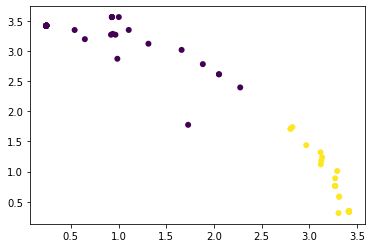

In [10]:
import matplotlib.pyplot as plt
plt.scatter(x=senator_distances[:,0], y=senator_distances[:,1], c=labels, linewidths=0)
plt.show()

# 10. Finding the most extreme

The most extreme Senators are those who are the furthest away from one cluster. For example, a radical Republican would be as far from the Democratic cluster as possible. Senators who are in between both clusters are more moderate, as they fall in between the views of the two parties.

If we look at the first few rows of senator_distances, we can start to see who is more extreme:

In [11]:
extremism = (senator_distances ** 3).sum(axis=1)
votes["extremism"] = extremism
votes.sort_values("extremism", inplace=True, ascending=False)
print(votes.head(10))

         name party state  00001  00004  00005  00006  00007  00008  00009  \
98     Wicker     R    MS    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
53   Lankford     R    OK    0.0    1.0    1.0    0.0    1.0    0.0    1.0   
69       Paul     R    KY    0.0    1.0    1.0    0.0    1.0    0.0    1.0   
80      Sasse     R    NE    0.0    1.0    1.0    0.0    1.0    0.0    1.0   
26       Cruz     R    TX    0.0    1.0    1.0    0.0    1.0    0.0    1.0   
48    Johnson     R    WI    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
47    Isakson     R    GA    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
65  Murkowski     R    AK    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
64      Moran     R    KS    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
30       Enzi     R    WY    0.0    1.0    1.0    1.0    1.0    0.0    1.0   

    00010  00020  00026  00032  00038  00039  00044  00047  extremism  
98    0.0    1.0    1.0    0.0    0.0    1.0    0.0    0.0  46.250476

`Clustering is a powerful way to explore data and find patterns. Unsupervised learning is very commonly used with large datasets where it isn't obvious how to start with supervised machine learning. In general, it's a good idea to try unsupervised learning to explore a dataset before trying to use supervised learning machine learning models.
`